In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import torch
from torch.utils import data as torchdata
import glob
import os
import warnings
import itertools
#import altair as alt
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano
from sklearn import preprocessing
import re

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
#df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n100_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path_sim = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n5500_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path = '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv'

Failed to import duecredit due to No module named 'duecredit'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# PyMC 

## ADVI

In [2]:
#df_sim = pd.read_csv(df_path_sim)
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)

In [9]:
model = sfp.monte_carlo.setup_model(df_sim)

In [10]:
with model:
    advi=pm.ADVI()
    advi_fit = advi.fit(10000, obj_optimizer=pm.adam(learning_rate=.01), )#more_replacements=map_tensor_batch,)# callbacks=[tracker])

Average Loss = -5,401.4: 100%|██████████| 10000/10000 [00:05<00:00, 1704.01it/s]
Finished [100%]: Average Loss = -5,401.4


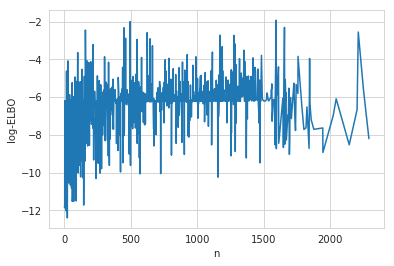

In [11]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [12]:
advi_trace = advi_fit.sample(500)

In [13]:
pm.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
voxel_norm,0.259179,0.004831,0.000194,0.249980,0.269167
sigma,0.995364,0.018782,0.000757,0.951151,1.026065
sf_ecc_slope,0.509445,0.008101,0.000373,0.492128,0.523162
sf_ecc_intercept,0.448265,0.028002,0.001332,0.394971,0.500991


/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


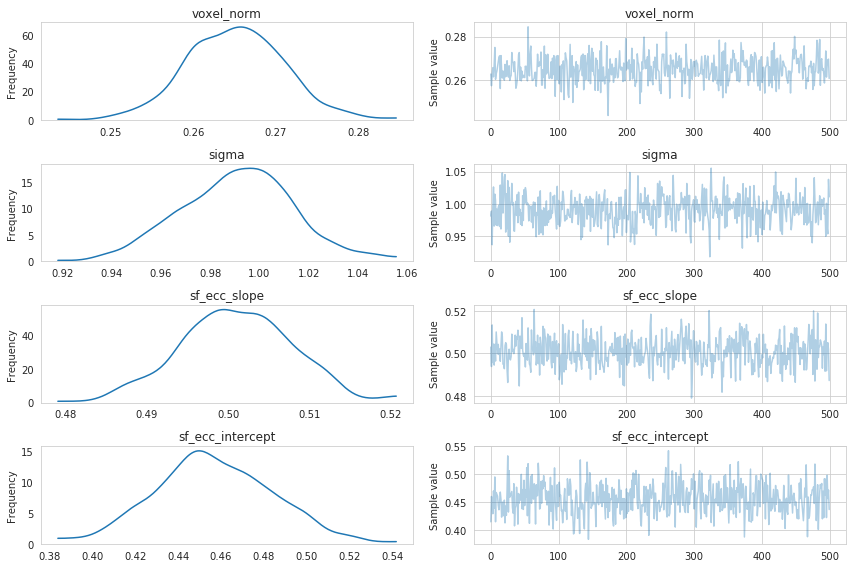

In [157]:
pm.traceplot(advi_trace);#, ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']);

## MCMC

In [190]:
df_paths = ['/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj001/ses-01/sub-wlsubj001_ses-01_task-sfp_v1_e1-12_summary.csv',
            '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-03/sub-wlsubj045_ses-03_task-sfp_v1_e1-12_summary.csv']
subjects = ['sub-wlsubj001', 'sub-wlsubj045']
sessions = ['ses-01', 'ses-03']
tasks = ['task-sfp', 'task-sfp']
sigmas = [1, 1.5]
slopes = [.1, .2]
intercepts = [.3, .5]
df_sim = []
for i, (subj, ses, task, s, a, b, noise) in enumerate(zip(subjects, sessions, tasks, sigmas, slopes, intercepts, df_paths)):
    tmp = sfp.simulate_data.main('iso', 'full', False, sigma=s, sf_ecc_intercept=b, sf_ecc_slope=a, num_voxels=100, noise_source_path=noise, noise_level=1)
    tmp['subject'] = subj
    tmp['session'] = ses
    tmp['task'] = task
    df_sim.append(tmp)
df_sim = pd.concat(df_sim)
df_sim['indicator'] = df_sim.apply(lambda x: str((x.subject, x.session, x.task)), 1)

In [317]:
model_fits = {}

In [345]:
model = sfp.monte_carlo.setup_model(df_sim, hierarchy_type='partially pooled')

Started with 100 voxels, after filtering with df_filter_string None have 100 voxels
Will fit partially pooled model, parameters for all 2 sessions share hyperparams!


In [346]:
model

In [348]:
with model:
    trace = pm.sample(500, n_chains=4, cores=4, init='jitter+adapt_diag', tune=2000, nuts_kwargs={'target_accept': .90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [voxel_norm, sf_ecc_intercept, sf_ecc_intercept_sd, sf_ecc_intercept_mu, sf_ecc_slope, sf_ecc_slope_sd, sf_ecc_slope_mu, sigma, sigma_sd, sigma_mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [03:16<00:00, 50.85draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [352]:
with model:
    post = pm.sample_posterior_predictive(trace)

100%|██████████| 2000/2000 [00:05<00:00, 386.65it/s]


In [353]:
inference_data = az.from_pymc3(trace, posterior_predictive=post)

In [356]:
model_fits['partially pooled'] = inference_data

In [354]:
az.summary(inference_data)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm[0],0.22,0.00,0.00,0.21,0.22,1917.0,1.0
voxel_norm[1],0.19,0.00,0.00,0.19,0.20,1955.0,1.0
sigma_mu,1.59,0.33,0.01,1.01,2.23,1726.0,1.0
sigma_sd,0.70,0.42,0.01,0.14,1.49,1843.0,1.0
sigma[0],1.01,0.01,0.00,0.98,1.03,1935.0,1.0
sigma[1],1.51,0.03,0.00,1.46,1.56,1834.0,1.0
sf_ecc_slope_mu,0.27,0.16,0.00,0.06,0.59,1460.0,1.0
sf_ecc_slope_sd,0.32,0.31,0.00,0.02,0.90,1402.0,1.0
sf_ecc_slope[0],0.10,0.00,0.00,0.10,0.11,1820.0,1.0
sf_ecc_slope[1],0.21,0.01,0.00,0.19,0.23,1391.0,1.0


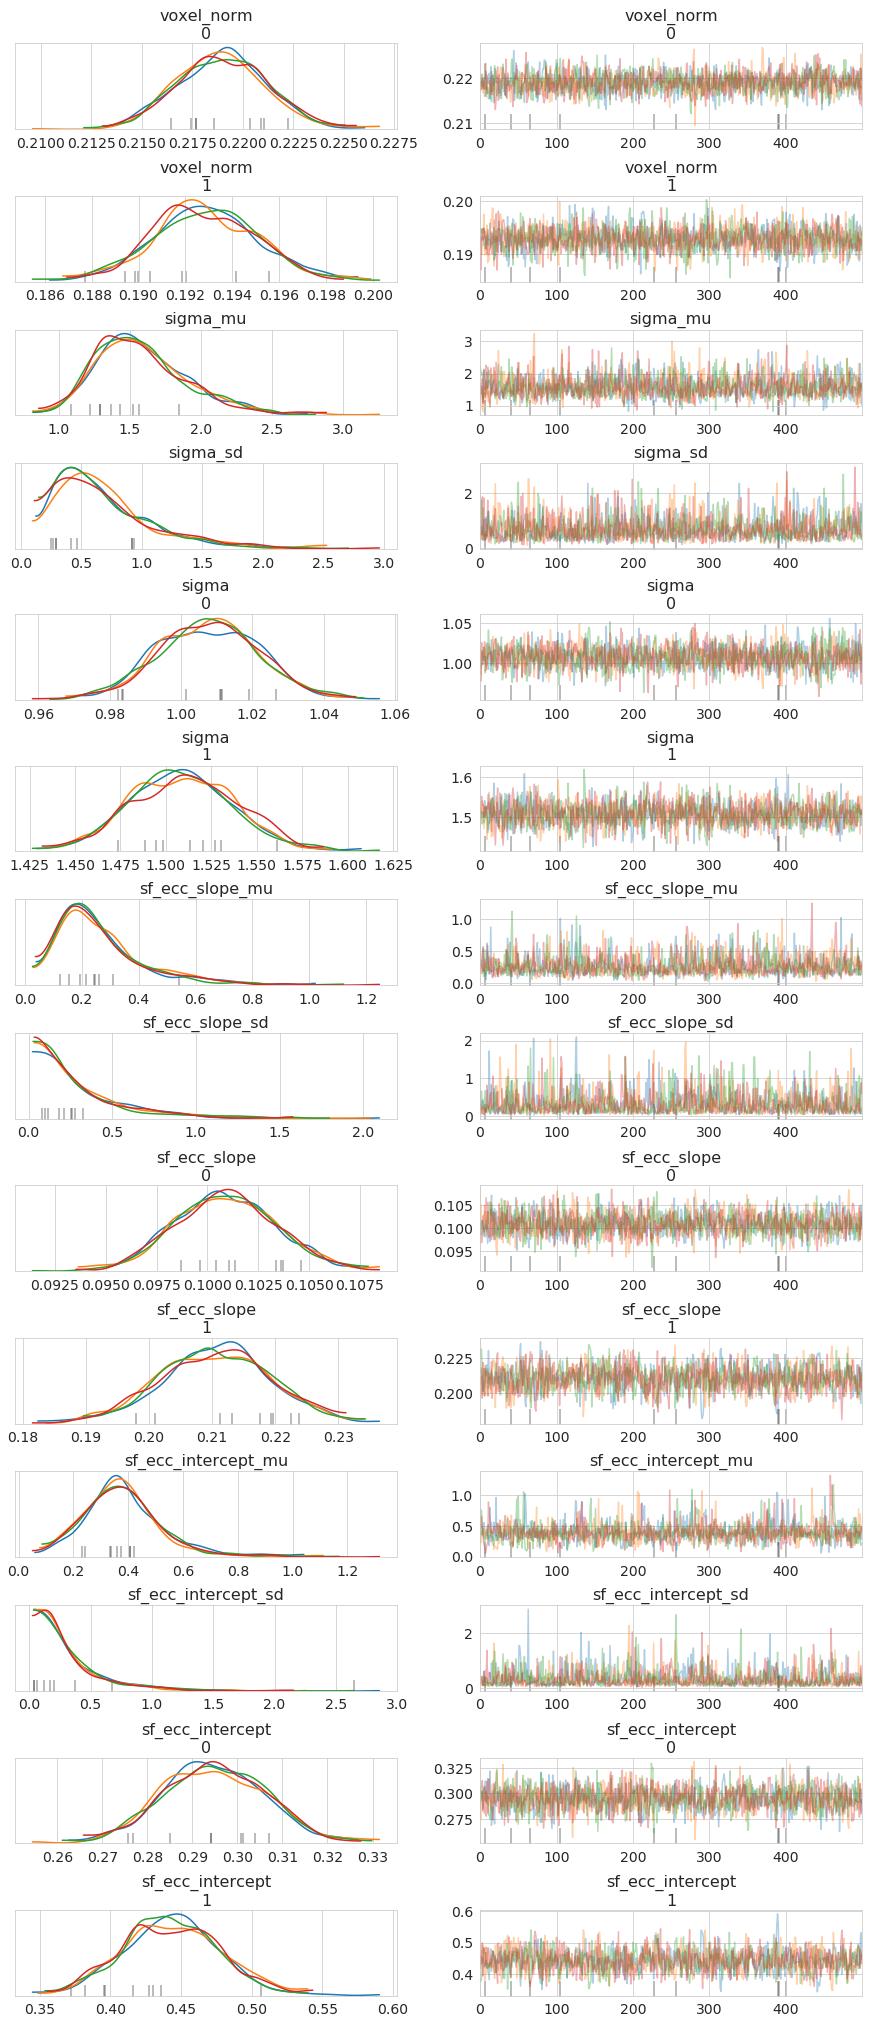

In [355]:
az.plot_trace(inference_data);

In [357]:
az.compare(model_fits, scale='log')

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
partially pooled,12379.9,0.481644,0,0.492266,53.724,0,0,log
unpooled,12379.9,0.480563,0.0131429,0.507734,53.7237,0.0228877,0,log
pooled,11681.4,1.25819,698.491,0,51.2934,13.6452,0,log


In [358]:
az.compare(model_fits, 'loo', scale='log')

,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
partially pooled,12379.9,0.48165,0,0.492267,53.724,0,0,log
unpooled,12379.9,0.48057,0.0131437,0.507733,53.7237,0.0228874,0,log
pooled,11681.4,1.25819,698.491,0,51.2934,13.6452,0,log


In [361]:
inference_data.posterior

<xarray.Dataset>
Dimensions:                 (chain: 4, draw: 500, sf_ecc_intercept_dim_0: 2, sf_ecc_slope_dim_0: 2, sigma_dim_0: 2, voxel_norm_dim_0: 2)
Coordinates:
  * chain                   (chain) int64 0 1 2 3
  * draw                    (draw) int64 0 1 2 3 4 5 ... 494 495 496 497 498 499
  * voxel_norm_dim_0        (voxel_norm_dim_0) int64 0 1
  * sigma_dim_0             (sigma_dim_0) int64 0 1
  * sf_ecc_slope_dim_0      (sf_ecc_slope_dim_0) int64 0 1
  * sf_ecc_intercept_dim_0  (sf_ecc_intercept_dim_0) int64 0 1
Data variables:
    voxel_norm              (chain, draw, voxel_norm_dim_0) float64 0.2177 ... 0.1917
    sigma_mu                (chain, draw) float64 1.642 1.377 ... 1.695 1.603
    sigma_sd                (chain, draw) float64 0.3325 0.3253 ... 0.4066
    sigma                   (chain, draw, sigma_dim_0) float64 1.001 ... 1.519
    sf_ecc_slope_mu         (chain, draw) float64 0.2036 0.2462 ... 0.1584
    sf_ecc_slope_sd         (chain, draw) float64 0.1129 0.118

# Actual results

## First attempt

It worked with the `advi+adapt_diag` initialization, but not with `adapt_diag` or `jitter+adapt_diag`

In [363]:
inference_data_1 = az.load_data('/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial/sub-wlsubj001/ses-01/sub-wlsubj001_ses-01_task-sfp_v1_e1-12_summary_s500_c8_i-advi+adapt_diag_ntarget_accept=.9_mcmc.nc')
inference_data_2 = az.load_data('/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary_s500_c8_i-advi+adapt_diag_ntarget_accept=.9_mcmc.nc')

In [366]:
inference_data_jt = az.load_data("/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial_multisubj/v1_e1-12_s500_c8_i-advi+adapt_diag_ntarget_accept=.9_unpooled_mcmc.nc")

In [74]:
az.summary(inference_data_1)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm,0.16,0.0,0.0,0.16,0.16,2319.0,1.0
sigma,2.37,0.0,0.0,2.37,2.38,2285.0,1.0
sf_ecc_slope,0.13,0.0,0.0,0.12,0.13,1795.0,1.0
sf_ecc_intercept,0.36,0.0,0.0,0.35,0.36,1899.0,1.0


In [75]:
az.summary(inference_data_2)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm,0.17,0.0,0.0,0.17,0.17,2944.0,1.0
sigma,1.93,0.0,0.0,1.93,1.93,2123.0,1.0
sf_ecc_slope,0.14,0.0,0.0,0.14,0.14,1916.0,1.0
sf_ecc_intercept,0.19,0.0,0.0,0.19,0.19,1941.0,1.0


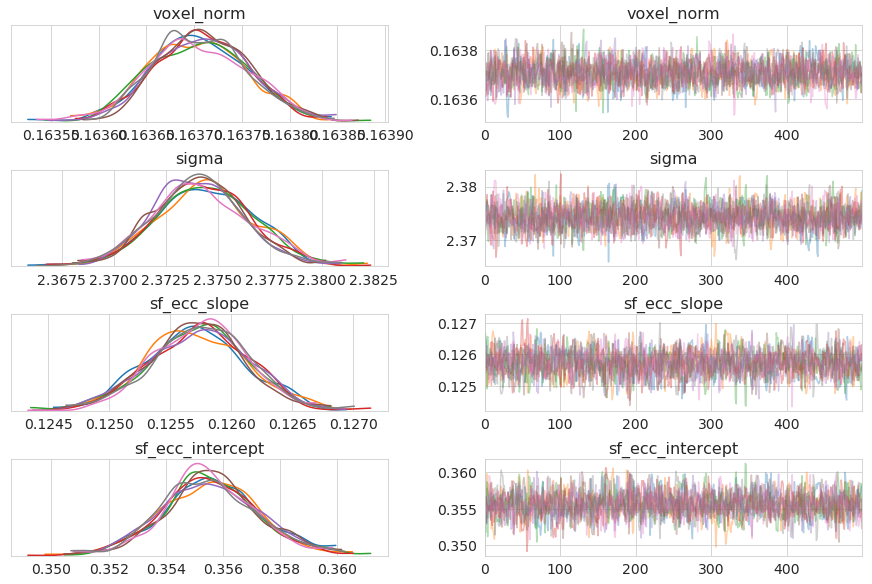

In [76]:
az.plot_trace(inference_data_1);

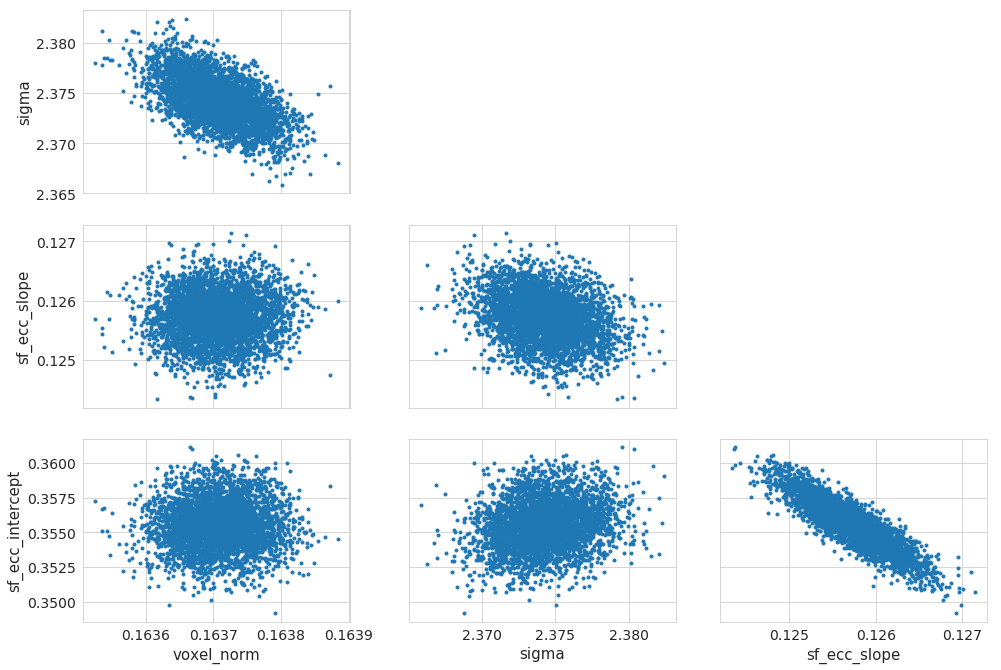

In [77]:
az.plot_pair(inference_data_1);

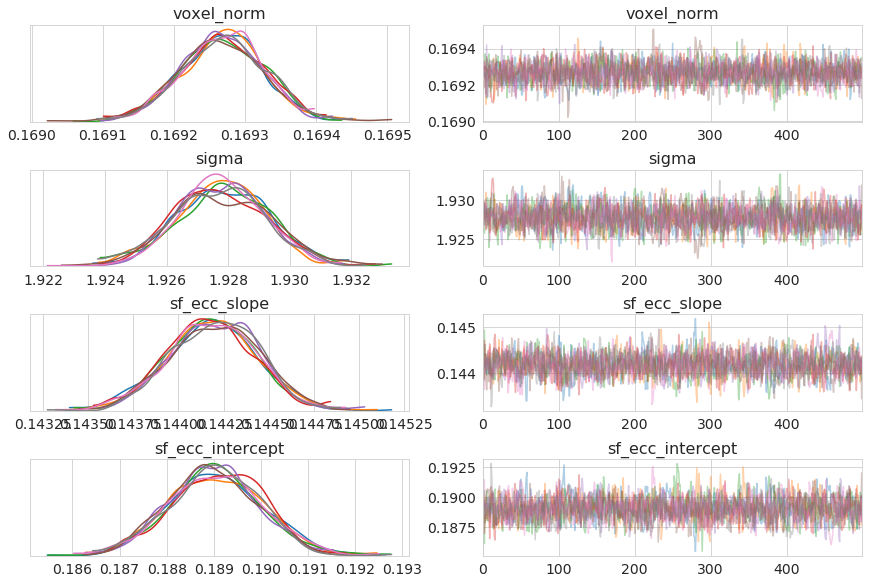

In [78]:
az.plot_trace(inference_data_2);

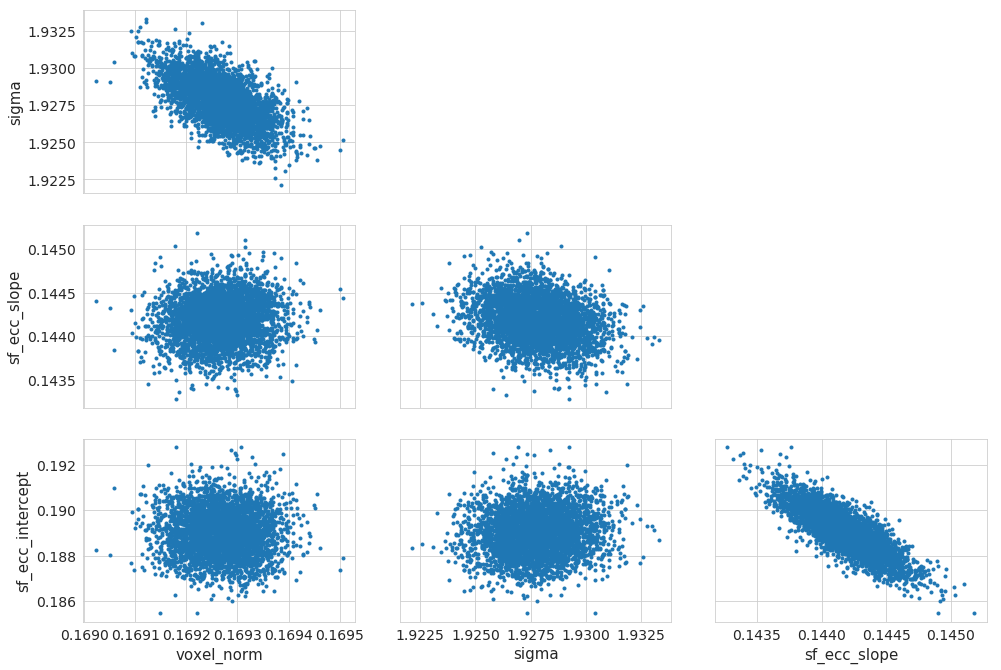

In [79]:
az.plot_pair(inference_data_2);

## Investigating what's going on

In [372]:
paths = ['/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv',
         '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj001/ses-01/sub-wlsubj001_ses-01_task-sfp_v1_e1-12_summary.csv']
df = []
for path in paths:
    tmp = pd.read_csv(path)
    if 'first_level_analysis' in path:
        tmp['session'] = path.split(os.sep)[-2]
        tmp['subject'] = path.split(os.sep)[-3]
        tmp['task'] = re.search('_(task-[a-z0-9]+)_', path).groups()[0]
        tmp['indicator'] = tmp.apply(lambda x: str((x.subject, x.session, x.task)), 1)
    df.append(tmp)
df = pd.concat(df)

In [373]:
df_filter = sfp.model.construct_df_filter('drop_voxels_with_negative_amplitudes,drop_voxels_near_border')

In [374]:
df = df_filter(df)

In [376]:
all_voxels = df.voxel.unique()
np.random.shuffle(all_voxels)
np.random.seed(2)
splits = np.array_split(all_voxels, 10)
good_starts = []

In [380]:
tmp = df.query('voxel in @splits[0]')

In [453]:
model = sfp.monte_carlo.setup_model(tmp, hierarchy_type='unpooled')
with model:
    trace = pm.sample(10000, step=pm.Metropolis(), chains=4, cores=4, tune=3000, init='advi+adapt_diag', discard_tuned_samples=False)

Started with 758 voxels, after filtering with df_filter_string None have 758 voxels
INFO:pymc3:Started with 758 voxels, after filtering with df_filter_string None have 758 voxels
Will fit unpooled model, separate parameters for each of 2 sessions
INFO:pymc3:Will fit unpooled model, separate parameters for each of 2 sessions
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [sf_ecc_intercept]
INFO:pymc3:>Metropolis: [sf_ecc_intercept]
>Metropolis: [sf_ecc_slope]
INFO:pymc3:>Metropolis: [sf_ecc_slope]
>Metropolis: [sigma]
INFO:pymc3:>Metropolis: [sigma]
>Metropolis: [voxel_norm]
INFO:pymc3:>Metropolis: [voxel_norm]
Sampling 4 chains: 100%|██████████| 52000/52000 [03:44<00:00, 231.29draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.

In [401]:
with model:
    #prior = pm.sample_prior_predictive(500)
    post = pm.sample_posterior_predictive(trace, 500)

100%|██████████| 500/500 [00:04<00:00, 115.11it/s]


In [454]:
data= az.from_pymc3(trace,)# posterior_predictive=post)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


MemoryError: 

In [451]:
az.summary(inference_data_jt)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm[0],0.16,0.0,0.0,0.16,0.16,3901.0,1.0
voxel_norm[1],0.17,0.0,0.0,0.17,0.17,3828.0,1.0
sigma[0],2.37,0.0,0.0,2.37,2.38,3393.0,1.0
sigma[1],1.93,0.0,0.0,1.92,1.93,4194.0,1.0
sf_ecc_slope[0],0.13,0.0,0.0,0.12,0.13,3138.0,1.0
sf_ecc_slope[1],0.14,0.0,0.0,0.14,0.14,2710.0,1.0
sf_ecc_intercept[0],0.36,0.0,0.0,0.35,0.36,3121.0,1.0
sf_ecc_intercept[1],0.19,0.0,0.0,0.19,0.19,3126.0,1.0


In [450]:
az.summary(data.posterior.sel({'draw': range(7000, 8000)}))

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm[0],0.16,0.00,0.00,0.16,0.16,237.0,1.02
voxel_norm[1],0.17,0.00,0.00,0.17,0.17,2.0,3.48
sigma[0],2.36,0.01,0.00,2.35,2.38,108.0,1.04
sigma[1],1.97,0.01,0.00,1.95,1.99,2.0,2.94
sf_ecc_slope[0],0.13,0.00,0.00,0.13,0.13,37.0,1.12
sf_ecc_slope[1],0.16,0.02,0.01,0.14,0.19,2.0,27.17
sf_ecc_intercept[0],0.34,0.00,0.00,0.33,0.35,42.0,1.10
sf_ecc_intercept[1],0.13,0.08,0.03,0.00,0.18,2.0,32.72


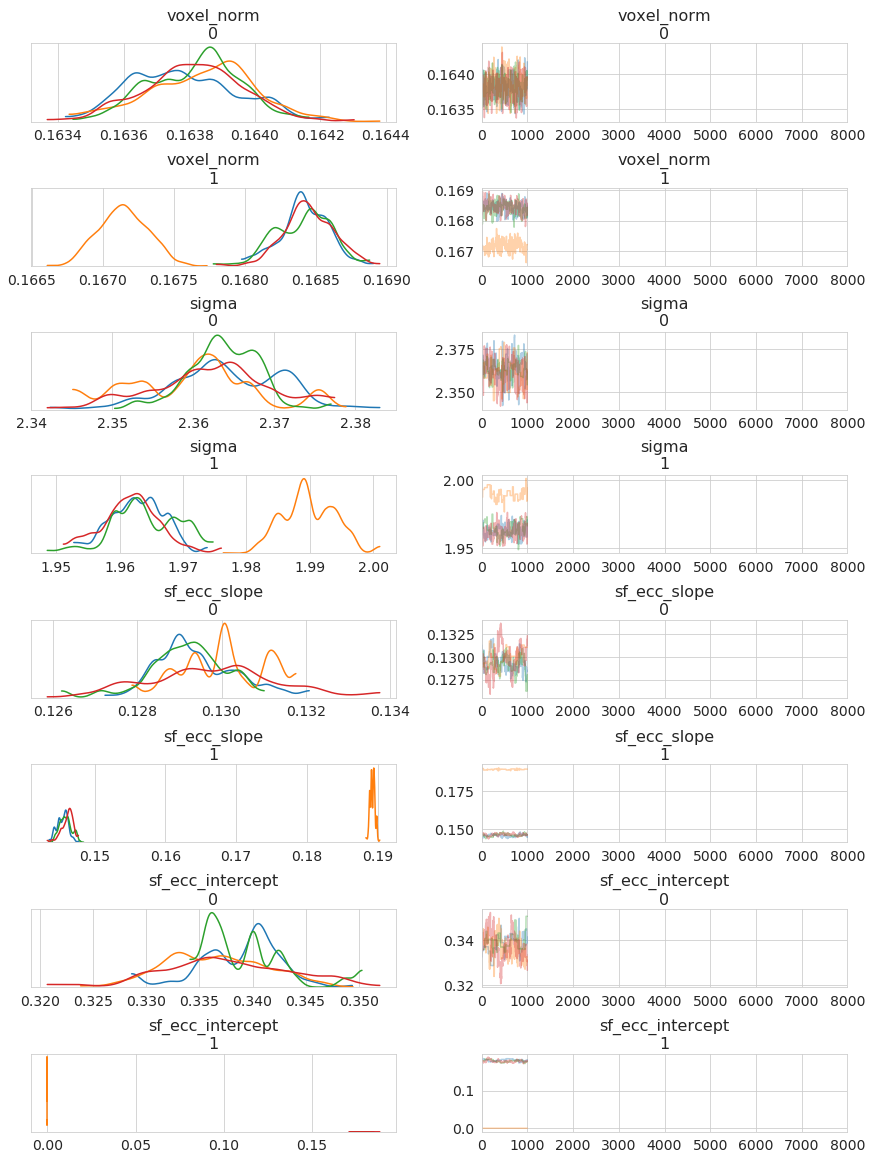

In [449]:
az.plot_trace(data.posterior.sel({'draw': range(7000, 8000)}));

In [440]:
az.plot_trace(data[-1000:]);

TypeError: 'InferenceData' object is not subscriptable